In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
import theano.tensor as tt
import arviz as az

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.8


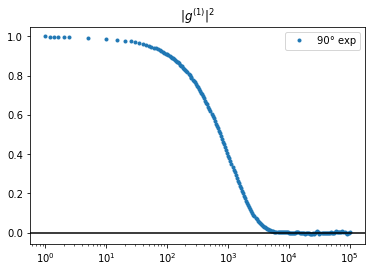

In [77]:
from MultiAngleDls import multiAngleDls

filelist = ['test_data\PS_300nm_90degree.dat']
data = multiAngleDls(filelist, d_min=1, d_max=300, d_num=50)
data.plotOriginalData()  

In [78]:
model = pm.Model()

tau = data.dlsDataList[0].tau * 1e-6
g1square_exp = data.dlsDataList[0].g1square
M = tau.size

# 构建 prior
from pymc3.distributions.continuous import BoundedContinuous
from pymc3.distributions.dist_math import bound

# 这里试着建立一个指数分布
class prior(BoundedContinuous):
    def __init__(self, lower=0, lam=1, *args, **kwargs):
        self.lower = lower = tt.as_tensor_variable(lower)
        self.lam = lam = tt.as_tensor_variable(lam)

        super().__init__(lower=lower,  *args, **kwargs)

    def logp(self, value):
        # value here is gamma
        lower = self.lower
        lam = self.lam
        return bound( -lam*(value-lower), value >= lower)


# 构建 likelihood
from pymc3.distributions import Continuous

testg1square = np.exp(-1*100*tau)**2
class likelihood(Continuous):

    def __init__(self, g1square_theo=testg1square, M=200, *args, **kwargs):
        self.g1square_theo = g1square_theo = tt.as_tensor_variable(g1square_theo)
        self.M = M = tt.as_tensor_variable(M)

        super().__init__(*args, **kwargs)

    def logp(self, value):
        # value here is g1square
        g1square_theo = self.g1square_theo
        M = self.M
        return -M/2 * tt.log( tt.sum( (value - g1square_theo)**2 ) )

kb = 1.38064852e-23                                 # Boltzmann Constant
theta = data.dlsDataList[0].angle / 180 * np.pi     # rad
Lambda = data.dlsDataList[0].wavelength * 1e-9      # in meter
T = data.dlsDataList[0].temperature                 # in Kelvin
eta = data.dlsDataList[0].viscosity * 1e-3          # viscosity, in Pa.s
n =data.dlsDataList[0].RI_liquid
Int = data.dlsDataList[0].intensity                 # intensity, should be cps

with model:
    d = prior('d', lower=10, lam=0.01, testval=50)

    gamma0 = (16 * np.pi * n**2 * kb * T)/(3 * Lambda**2 * eta) * np.sin(theta/2)**2
    g1square_theo = tt.exp(-gamma0/(d*1e-9)*tau)**2

    like = likelihood('like', g1square_theo=g1square_theo, M=M, shape=(M,1), testval=testg1square, observed=g1square_exp)


In [79]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step, cores=1, chains=1, tune=2000, discard_tuned_samples=True)
trace['d'].shape

Sequential sampling (1 chains in 1 job)
Metropolis: [d]
Sampling chain 0, 0 divergences: 100%|██████████| 7000/7000 [00:00<00:00, 8682.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


(5000,)

In [80]:
az.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
d,354.961,0.378,354.254,355.645,0.014,0.01,688.0,688.0,687.0,788.0,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028CAD6CA7C8>,
      dtype=object)

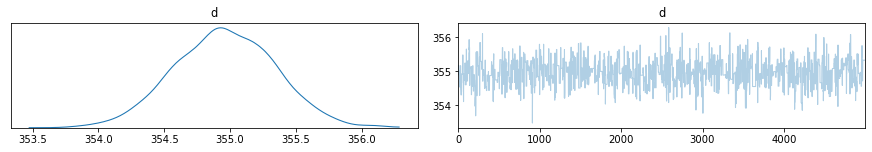

In [81]:
az.plot_trace(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028CABFB0CC8>],
      dtype=object)

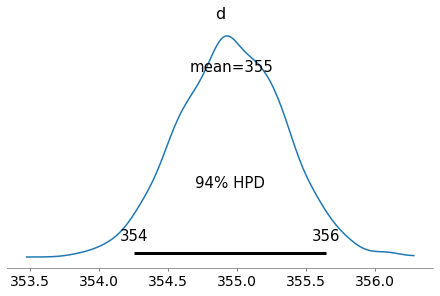

In [82]:
az.plot_posterior(trace)